In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [10]:
import examples as eg
import dionysus

The circular coordinates pipeline for examining different smoothness cost-functions:

    Step 1. Getting the point cloud
    Step 2. Computing the Vietoris-Rips filtration and its cohomology
    Step 3. Selecting the Cocycle
    Step 4. First smoothing using Least Squares (Optional)
    Step 5. Second smoothing using a new cost function

## Step 1 - Getting the point cloud

In [8]:
annulus = eg.annulus_variable_d_example()

## Step 2 - Computing VR and Cohomology

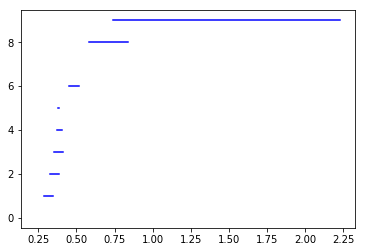

In [11]:
prime = 23 #choose the prime

vr = dionysus.fill_rips(annulus, 2, 4.)
cp = dionysus.cohomology_persistence(vr, prime, True)
dgms = dionysus.init_diagrams(cp, vr)
dionysus.plot.plot_bars(dgms[1], show=True)

## Step 3 - Selecting the cocycle

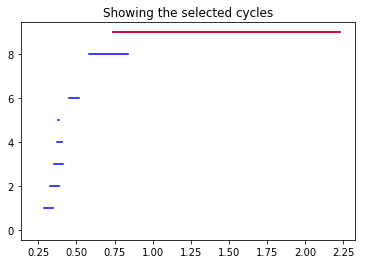

In [21]:
bars = [bar for bar in dgms[1] if bar.death-bar.birth > 1.] #choosing cocycle that persist at least 1.
cocycles = [cp.cocycle(bar.data) for bar in bars]

dionysus.plot.plot_bars(dgms[1], show=False)
plt.plot([[bar.birth,bar.death] for bar in dgms[1] if bar.death-bar.birth > 1.][0],[[x,x] for x,bar in enumerate(dgms[1]) if bar.death-bar.birth > 1.][0],'r')
plt.title('Showing the selected cycles')
plt.show()

## Step 4 - First smoothing using Least Squares (Optional)

If it is computed the smoothed coefficients can be used as initial condition for the optimization code

In [24]:
vr_8 = dionysus.Filtration([s for s in vr if s.data <= max([bar.birth for bar in bars])])
coords = [dionysus.smooth(vr_8, cocycle, prime) for cocycle in cocycles]

### Visualization

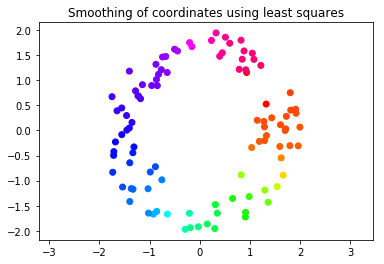

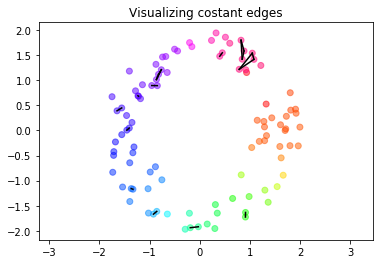

In [28]:
scatter(*annulus.T, c=coords[0], cmap="hsv")
plt.axis('equal')
plt.title('Smoothing of coordinates using least squares')
plt.show()

toll = 1e-5
for p,val in zip(bars,coords):
    edges_costant = []
    thr = p.birth # i want to check all edges that were there when the cycle was created
    for s in vr:
        if s.dimension() != 1:
            continue
        elif s.data > thr:
            break
        if abs(val[s[0]]-val[s[1]]) <= toll:
            edges_costant.append([annulus[s[0],:],annulus[s[1],:]])
    edges_costant = np.array(edges_costant)        
    scatter(*annulus.T, c=val, cmap="hsv", alpha=.5)
    plot(*edges_costant.T, c='k')
    plt.axis('equal')
    plt.title('Visualizing constant edges')
    plt.show()

## Step 5 - Second smoothing using a new cost function

In [78]:
def coboundary_1(vr, thr):
    import scipy as sp
    D = {}
    data = {}
    indexing = {}
    ix = [0]*2
    for s in vr:
        if s.dimension() != 1:
            continue
        elif s.data > thr:
            break
        D.setdefault(s.dimension(),[[],[]])
        data.setdefault(s.dimension(),[])
        indexing.setdefault(s.dimension(),{})
        indexing.setdefault(s.dimension()-1,{})
        if not s in indexing[s.dimension()]:
            indexing[s.dimension()][s] = ix[s.dimension()]
            ix[s.dimension()] += 1
        for dat, k in enumerate(s.boundary()): 
            if not k in indexing[s.dimension()-1]:
                indexing[k.dimension()][k] = ix[k.dimension()]
                ix[k.dimension()] += 1
            D[s.dimension()][0].append(indexing[s.dimension()][s]) #rows
            D[s.dimension()][1].append(indexing[k.dimension()][k]) #cols
            data[s.dimension()].append(1. if dat % 2 == 0 else -1.)
    return sp.sparse.csr_matrix((data[1], (D[1][0], D[1][1]))), indexing

In [81]:
bdry,indexing = coboundary_1(vr,max(bar.death for bar in bars))

In [82]:
n, m = bdry.shape # edges X nodes
bdry


<2342x100 sparse matrix of type '<class 'numpy.float64'>'
	with 4684 stored elements in Compressed Sparse Row format>

In [83]:

l2_cocycle = [0]*len(coords[0]) #reorganize the coordinates so they fit with the coboundary indices
for i, coeff in enumerate(coords[0]):
    l2_cocycle[indexing[0][dionysus.Simplex([i],0)]] = coeff
l2_cocycle = np.array(l2_cocycle)
#-----------------
f = np.zeros((n,1)) # cocycle we need to smooth out, reorganize to fit coboundary
for c2 in cocycles[0]:
    if c2.element<(prime//2):
        f[indexing[1][vr[c2.index]]] += c2.element
    else:
        f[indexing[1][vr[c2.index]]] += c2.element-prime       

In [88]:
import cost_functions
from scipy.optimize import minimize
l= 0.
cost = lambda z: cost_functions.cost_interpolate(z, L= l, F= f, B= bdry)
grad = lambda z: cost_functions.grad_interpolate(z, L= l, F= f, B= bdry)
res = minimize(cost, l2_cocycle, method='L-BFGS-B', jac = grad)
Zv = np.array(res.x).reshape(bdry.shape[1],1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(bdry.shape[1])]
color = np.mod(Zv.T[:,messed_ix],1)[0]

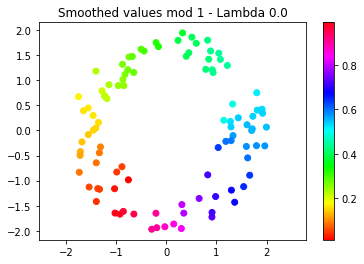

In [89]:

scatter(*annulus.T, c=color, cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('Smoothed values mod 1 - Lambda {}'.format(l))
plt.show()